# **Regressão Logística - pt. II**

Agora que já aprendemos a ajustar uma regressão logística a um conjunto de dados, podemos aprofundar a nossa análise para entender como o limite mínimo de probabilidade altera os resultados.

Primeiramente, vamos realizar a modelagem novamente e estimar as probabilidades, dessa vez:

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, \
                            precision_score, recall_score, precision_recall_curve, \
                            roc_curve, roc_auc_score

# ignorar warnings
warnings.filterwarnings('ignore')

In [2]:
# montando drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# lendo os dados
PATH = '/content/drive/MyDrive/Bootcamp_DataScience/AlgoritmosInteligenciaArtificialClassificacao/datasets/german_credit.csv'
data = pd.read_csv(PATH)
data.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [5]:
# (opcional) modificar os nomes das colunas
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
data.head(1)

,creditability,account_balance,duration_of_credit_month,payment_status_of_previous_credit,purpose,credit_amount,value_savings/stocks,length_of_current_employment,instalment_per_cent,sex_&_marital_status,...,duration_in_current_address,most_valuable_available_asset,age_years,concurrent_credits,type_of_apartment,no_of_credits_at_this_bank,occupation,no_of_dependents,telephone,foreign_worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1


In [6]:
# para iniciar - apenas variáveis numéricas (reais)
data = data[['creditability', 'credit_amount', 'age_years', 'duration_of_credit_month',
             'concurrent_credits', 'length_of_current_employment', 'no_of_dependents']]
data.head()

,creditability,credit_amount,age_years,duration_of_credit_month,concurrent_credits,length_of_current_employment,no_of_dependents
0,1,1049,21,18,3,2,1
1,1,2799,36,9,3,3,2
2,1,841,23,12,3,4,1
3,1,2122,39,12,3,3,2
4,1,2171,38,12,1,3,1


In [7]:
# separando x e y
x = data.drop(['creditability'], axis=1)
y = data[['creditability']]

In [9]:
# separando treino e teste - com estratificação
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [10]:
# criando um pipeline de modelagem
pipe_rl = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('rl2', LogisticRegression(penalty=None))
])

# ajustando o pipeline
pipe_rl.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rl2', LogisticRegression(penalty=None))])

Normalmente, usamos o método `.predict()` para obter as classes que cada uma das amostras pertence.

No entanto, podemos usar também o método `.predict_proba()` para obter as estimativas de probabilidade de pertencimento.

In [14]:
# quero fazer a previsão de uma única linha
row = x_test.iloc[[0], :]
row

,credit_amount,age_years,duration_of_credit_month,concurrent_credits,length_of_current_employment,no_of_dependents
311,2751,38,48,3,5,2


In [15]:
# previsão das probabilidades
probs = pipe_rl.predict_proba(row)
probs

array([[0.46567165, 0.53432835]])

No caso acima, a classe escolhida seria a classe 1, visto que sua probabilidade de pertecimento é maior.

A probabilidade mínima para pertencer a uma classe é 0.5, por padrão. No entanto, podemos modificar esse limiar, conforme as necessidades do nosso negócio.

- se $p_{decision} > 0.5 \to$ dizemos que o modelo se torna mais **conservador**, pois será necessária uma "certeza maior" para que um ponto pertença a uma classe. Como efeito colateral, teremos um aumento de falsos negativos.

- se $p_{decision} < 0.5 \to$ dizemos que o modelo se torna mais **liberal**, pois será necessária uma "certeza menor" para que um ponto pertença a uma classe. Como efeito colateral, teremos um aumento de falsos positivos.

Façamos uma análise gráfica desse efeito:

In [16]:
# criando um vetor de probabilidades
prob_min = np.linspace(0.01, 0.99, 99)

# realizar as previsões das probabilidades de toda base de teste
prob_test = pipe_rl.predict_proba(x_test)

FP = []
FN = []

for p in prob_min:

  # calcular o vetor de classes
  yhat = [1 if c[1] > p else 0 for c in prob_test]

  # calcular a matriz de confusão
  mc = confusion_matrix(y_test, yhat)

  # adiciono nas listas
  FP.append(mc[0, 1] / y_test.shape[0])
  FN.append(mc[1, 0] / y_test.shape[0])

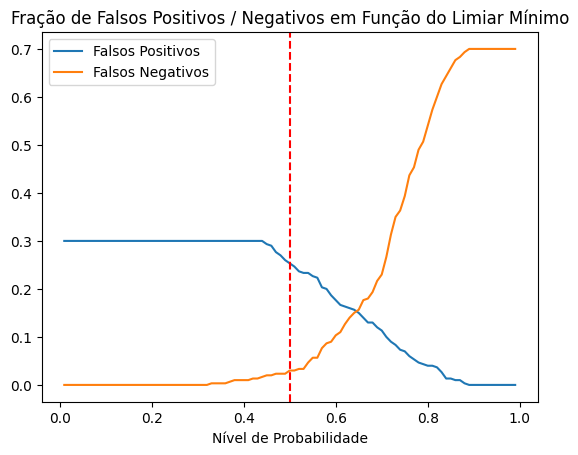

In [19]:
plt.plot(prob_min, FP, label='Falsos Positivos')
plt.plot(prob_min, FN, label='Falsos Negativos')
plt.title('Fração de Falsos Positivos / Negativos em Função do Limiar Mínimo')
plt.xlabel('Nível de Probabilidade')
plt.axvline(x=0.5, ls='--', color='red')
plt.legend()
plt.show()

In [20]:
# em termos de precisão e recall
precision = []
recall = []

for p in prob_min:

  # calcular o vetor de classes
  yhat = [1 if c[1] > p else 0 for c in prob_test]

  # adicionar às listas
  precision.append(precision_score(y_test, yhat))
  recall.append(recall_score(y_test, yhat))

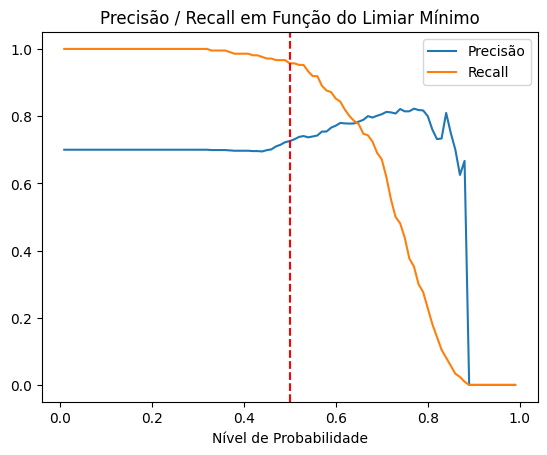

In [21]:
plt.plot(prob_min, precision, label='Precisão')
plt.plot(prob_min, recall, label='Recall')
plt.title('Precisão / Recall em Função do Limiar Mínimo')
plt.xlabel('Nível de Probabilidade')
plt.axvline(x=0.5, ls='--', color='red')
plt.legend()
plt.show()

Podemos olhar esses resultados em termos de métricas bem conhecidas:

- **Gráfico Recall x Precisão**
- **Curva ROC** - curva que plota a Taxa de Verdadeiros Positivos (TPR) contra a Taxa de Falsos Positivos (FPR)

In [22]:
prob_test[:5]

array([[0.46567165, 0.53432835],
       [0.53546772, 0.46453228],
       [0.19788813, 0.80211187],
       [0.24843863, 0.75156137],
       [0.31828272, 0.68171728]])

In [23]:
# avaliando a curva de recall e precisão
precision, recall, _ = precision_recall_curve(y_test, [c[1] for c in prob_test])

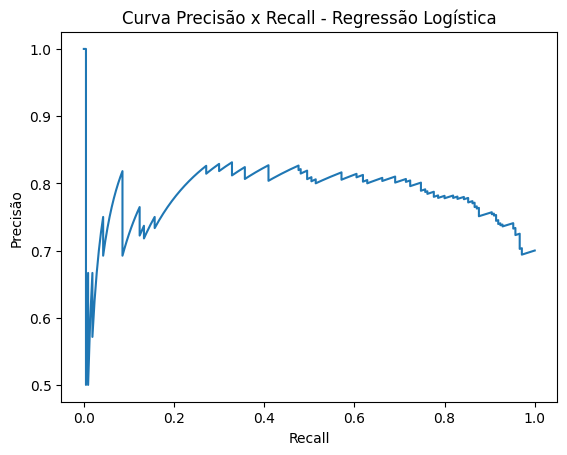

In [24]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precisão x Recall - Regressão Logística')
plt.show()

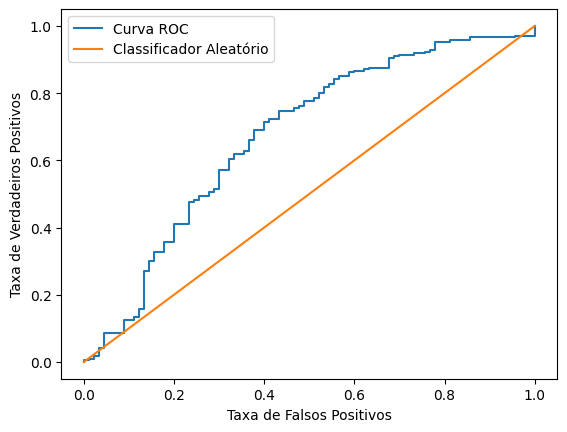

In [25]:
fpr, tpr, _ = roc_curve(y_test, [c[1] for c in prob_test])

plt.plot(fpr, tpr, label='Curva ROC')
plt.plot([0, 1], [0, 1], label='Classificador Aleatório')
plt.legend()
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.show()

In [26]:
# métrica de avalição rápida da ROC
print('Área abaixo da curva - AUC ROC: ', roc_auc_score(y_test, [c[1] for c in prob_test]))

Área abaixo da curva - AUC ROC:  0.6722222222222223


Por último, vamos adotar uma postura mais voltada aos negócios, considerando o lucro médio de cada cliente que foi classificado:

In [27]:
def profit(yreal, ypred):
  # calcular a matrix de confusão
  cm = confusion_matrix(yreal, ypred)

  # extrair as pontuações
  tp = cm[1, 1] # verdadeiros positivos
  fp = cm[0, 1] # falsos positivos
  tn = cm[0, 0] # verdadeiros negativos
  fn = cm[1, 0] # falsos negativos

  # lucro total
  lucro = (50 * tp) + (-5 * fn) + (-5 * tn) + (-150 * fp)

  # retornar o lucro médio por cliente
  return lucro / yreal.shape[0]

In [28]:
# avaliando o lucro médio em cada limiar
avg_profit = []

for p in prob_min:

  # calcular o vetor de classes
  yhat = [1 if c[1] > p else 0 for c in prob_test]

  # adicionar o lucro à lista
  avg_profit.append(profit(y_test, yhat))

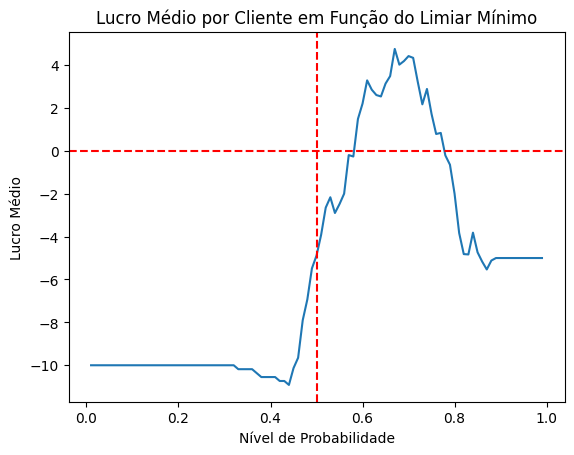

In [32]:
plt.plot(prob_min, avg_profit, label='Lucro Médio')
plt.ylabel('Lucro Médio')
plt.xlabel('Nível de Probabilidade')
plt.title('Lucro Médio por Cliente em Função do Limiar Mínimo')
plt.axhline(y=0, color='red', ls='--')
plt.axvline(x=0.5, color='red', ls='--')
plt.show()

- realizar a análise de limiar para o drug200 (condições da aula 2)
- determinar programaticamente o ponto de operação (lucro médio máximo) - para o Drug200